In [1]:
import unittest
import pandas as pd

from colorama import Fore, Back, Style 

from datetime import datetime

<h1>Import Code to be Tested</h1>

In [2]:
import devanalyst.simulation.statics as S_

import devanalyst.simulation.businessObjects as bo
from devanalyst.simulation.businessObjects import UserStory, UserStoriesRepo, Ticket, TicketsRepo, WorkItem, \
UserStoryStatus, Backlog, ScrumTeam, ScrumTeamsRepo, ReleaseCycleContext

from devanalyst.simulation.simulationModels import ModelsConfig, DefaultCostModel, GreedyAllocationModel, \
DistributedLagQualityModel

import devanalyst.simulation.generateTimecards as timecard
from devanalyst.simulation.generateTimecards import IdCounter, WorkAssignments, ReleaseLog

importing Jupyter notebook from c:\alejandro\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\statics.ipynb
importing Jupyter notebook from c:\alejandro\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\businessObjects.ipynb
importing Jupyter notebook from c:\alejandro\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\simulationModels.ipynb
importing Jupyter notebook from c:\alejandro\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\generateTimecards.ipynb


In [3]:
import devanalyst.simulation.tests.test_utils as tu_
from devanalyst.simulation.tests.test_utils import ExpectedOutputCleaner

importing Jupyter notebook from c:\alejandro\code\chateauclaudia-labs\devanalyst\devanalyst\simulation\tests\test_utils.ipynb


<h1>test_uss</h1>
<p>Test User Story Status</p>

In [ ]:
# Implement test logic, and run

# Helper methods to the test
def format_ticket(ticket):
    return ('Ticket:' + ticket.ticketId \
            + ',\n\t\t storyId=' + ticket.userStoryId \
            + ',\n\t\t costToFix=' + str(ticket.estimatedCost) \
            + ',\n\t\t sprintReported=' + str(ticket.sprintReported) \
            + ',\n\t\t sprintFixed=' + str(ticket.sprintFixed) \
            + ',\n\t\t effortToDate=' + str(ticket.effortToDate) \
            + ',\n\t\t percentAchieved=' + str(ticket.percentAchieved))
                
def format_tickets(tickets):
    output = ''
    for ticket in tickets:
        output = output + '\n\t\t{' + format_ticket(ticket) + '}'
    return output
            
def format_uss(uss, ctx):
    openTickets = ctx.ticketsRepo.getOpenTickets(uss.userStoryId)        
    return ('\n *** USS:' + uss.userStoryId \
            + '\n\t achieved=' + str(uss.percentAchieved) \
            + ',\n\t planned=' + str(uss.planned) \
            + ',\n\t sprintPlanned=' + str(uss.sprintPlanned) \
            + ',\n\t tickets=' + format_tickets(openTickets))

def format_item(item, item_label, sprint, timeInSprint):
    return ('\n *** ' + item_label + ' at ' + timeInSprint + ' of sprint' + str(sprint) + ': ' \
            + '\n\t userStoryId=' + str(item.userStoryId) \
            + ',\n\t taskType=' + str(item.taskType) \
            + ',\n\t ticketId=' + str(item.ticketId) \
            + ',\n\t estimate=' + '{0:.2f}'.format(item.estimate) \
            + ',\n\t percentAchieved=' + str(item.percentAchieved)  \
            + ',\n\t sprintPlanned=' + str(item.sprintPlanned))

# Test logic
def test_uss():
    output = '' 
    repo = UserStoriesRepo([UserStory('Story A', 25, 'Joe Developer', 'Amy PM'), \
                            UserStory('Story B', 17, 'Alex Developer', 'Kate PM')])
    # SPRINT 1
    ctx = ReleaseCycleContext(teamId='', teamsRepo=None, storiesRepo=repo, ticketsRepo=TicketsRepo(), sprint=1, sprintDuration=None)
    uss = UserStoryStatus('Story B', 0.0)
    uss.planned = True
    uss.sprintPlanned = 1
    output = output + (format_uss(uss, ctx))
    item = uss._generateWorkItems(ctx)[0]
    output = output + (format_item(item, 'Item#1', 1, 'start'))
    item.percentAchieved = 0.7
    
    ctx.ticketsRepo.addTicket(Ticket('Bug 100','Story B', 4, 1))
    ctx.ticketsRepo.addTicket(Ticket('Bug 101','Story B', 1.5, 1))
    
    output = output + (format_item(item, 'Item#1', 1, 'end'))
    uss.updateStatus([item], ctx)
    
    # SPRINT 2
    ctx.sprint = 2
    uss.sprintPlanned = 2
    output = output + (format_uss(uss, ctx))

    items = uss._generateWorkItems(ctx)
    item=items[0]
    output = output + (format_item(item, 'Item#1', 2, 'start'))
    item=items[1]
    output = output + (format_item(item, 'Item#2', 2, 'start'))
    item=items[2]
    output = output + (format_item(item, 'Item#3', 2, 'start'))
    items[0].percentAchieved = 0.9
    items[0].actual = 18.3
    items[1].percentAchieved = 1.0
    items[1].actual = 4.32
    items[2].percentAchieved = 0.5
    items[2].actual = 0.86
    item=items[0]
    output = output + (format_item(item, 'Item#1', 2, 'end'))
    item=items[1]
    output = output + (format_item(item, 'Item#2', 2, 'end'))
    item=items[2]
    output = output + (format_item(item, 'Item#3', 2, 'end'))
    uss.updateStatus(items, ctx)
    output = output + (format_uss(uss, ctx))
    return output

# Run the test
test_uss_ACTUAL = test_uss()

In [ ]:
# Uncomment to print a string output one can copy and paste into test_uss_EXPECTED
#test_uss_ACTUAL

In [ ]:
# Set expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK
test_uss_EXPECTED = '\n *** USS:Story B\n\t achieved=0.0,\n\t planned=True,\n\t sprintPlanned=1,\n\t tickets=\n *** Item#1 at start of sprint1: \n\t userStoryId=Story B,\n\t taskType=UNFINISHED_STORIES,\n\t ticketId=None,\n\t estimate=17.00,\n\t percentAchieved=0.0,\n\t sprintPlanned=1\n *** Item#1 at end of sprint1: \n\t userStoryId=Story B,\n\t taskType=UNFINISHED_STORIES,\n\t ticketId=None,\n\t estimate=17.00,\n\t percentAchieved=0.7,\n\t sprintPlanned=1\n *** USS:Story B\n\t achieved=0.7,\n\t planned=True,\n\t sprintPlanned=2,\n\t tickets=\n\t\t{Ticket:Bug 100,\n\t\t storyId=Story B,\n\t\t costToFix=4,\n\t\t sprintReported=1,\n\t\t sprintFixed=NOT_SET,\n\t\t effortToDate=0.0,\n\t\t percentAchieved=0.0}\n\t\t{Ticket:Bug 101,\n\t\t storyId=Story B,\n\t\t costToFix=1.5,\n\t\t sprintReported=1,\n\t\t sprintFixed=NOT_SET,\n\t\t effortToDate=0.0,\n\t\t percentAchieved=0.0}\n *** Item#1 at start of sprint2: \n\t userStoryId=Story B,\n\t taskType=UNFINISHED_STORIES,\n\t ticketId=None,\n\t estimate=5.10,\n\t percentAchieved=0.0,\n\t sprintPlanned=2\n *** Item#2 at start of sprint2: \n\t userStoryId=Story B,\n\t taskType=DEV_TIME_BUGS,\n\t ticketId=Bug 100,\n\t estimate=4.00,\n\t percentAchieved=0.0,\n\t sprintPlanned=2\n *** Item#3 at start of sprint2: \n\t userStoryId=Story B,\n\t taskType=DEV_TIME_BUGS,\n\t ticketId=Bug 101,\n\t estimate=1.50,\n\t percentAchieved=0.0,\n\t sprintPlanned=2\n *** Item#1 at end of sprint2: \n\t userStoryId=Story B,\n\t taskType=UNFINISHED_STORIES,\n\t ticketId=None,\n\t estimate=5.10,\n\t percentAchieved=0.9,\n\t sprintPlanned=2\n *** Item#2 at end of sprint2: \n\t userStoryId=Story B,\n\t taskType=DEV_TIME_BUGS,\n\t ticketId=Bug 100,\n\t estimate=4.00,\n\t percentAchieved=1.0,\n\t sprintPlanned=2\n *** Item#3 at end of sprint2: \n\t userStoryId=Story B,\n\t taskType=DEV_TIME_BUGS,\n\t ticketId=Bug 101,\n\t estimate=1.50,\n\t percentAchieved=0.5,\n\t sprintPlanned=2\n *** USS:Story B\n\t achieved=0.97,\n\t planned=True,\n\t sprintPlanned=2,\n\t tickets=\n\t\t{Ticket:Bug 101,\n\t\t storyId=Story B,\n\t\t costToFix=1.5,\n\t\t sprintReported=1,\n\t\t sprintFixed=NOT_SET,\n\t\t effortToDate=0.86,\n\t\t percentAchieved=0.5}'

tu_.EXPECTED['uss'] = test_uss_EXPECTED
tu_.ACTUAL['uss'] = test_uss_ACTUAL
tu_.testOK('uss')

In [ ]:
# Print ACTUAL output
print(Back.BLUE + Fore.WHITE + '--------------------- ACTUAL -------------------------', \
      Back.RESET + Fore.BLUE + '\n' + test_uss_ACTUAL) 

In [ ]:
# Print EXPECTED output
print(Back.GREEN + Fore.WHITE + '--------------------- EXPECTED -----------------------', \
      Back.RESET + Fore.GREEN + '\n' + test_uss_EXPECTED) 

<h1>test_createTeams</h1>

In [ ]:
# Implement test logic, and run

teams_df = bo.createTeamsDF(tu_.DEV_DF, tu_.PM_DF)

object_cols = ['Scrum Team'] # Need to drop these since they print always-chaning memory address + can't save it in EXPECTED
test_createTeams_ACTUAL = teams_df.drop(object_cols, axis='columns')

In [ ]:
# Uncomment to update expected output to match the actual one
#tu_.createExpectedOutput(test_createTeams_ACTUAL, 'test_createTeams')

In [ ]:
# Load expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK
list_cols = ['Developers', 'Product Managers', 'Areas of Responsibility']
test_createTeams_EXPECTED = tu_.loadExpectedOutput('test_createTeams', list_cols)

tu_.EXPECTED['createTeams'] = test_createTeams_EXPECTED
tu_.ACTUAL['createTeams'] = test_createTeams_ACTUAL
tu_.testOK('createTeams')

In [ ]:
test_createTeams_ACTUAL

In [ ]:
test_createTeams_EXPECTED

<h1>test_userStoryCreate</h1>
<p>This test has multiple views, each of which is checked separately</p>
<li>test_userStoryCreate_stories
<li>test_userStoryCreate_estimates
<li>test_userStoryCreate_crossCheck
<li>test_userStoryCreate_workload

In [ ]:
# Implement test logic, and run it

#Test logic
def test_userStoryCreate():
    output = {}
    RELEASE_DURATION = 125
    SPRINT_DURATION = 10
    NUMBER_OF_SPRINTS = 25

    # Configure models
    modelsConfig = ModelsConfig([DefaultCostModel()], [], GreedyAllocationModel()) 
    modelsConfig.random.reset(271)

    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, tu_.PM_DF, \
                                                                             RELEASE_DURATION, SPRINT_DURATION, modelsConfig)
        
    grouped_estimates_df = stories_df.groupby([ 'Scrum Team', 'Developer'])['Estimate'].sum()
    workload_df = stories_df.groupby([ 'Scrum Team'])['User Story Id'].count()
    #workload_count_df = workload_df.count()
    
    avg_estimates_df = grouped_estimates_df.unstack().apply(lambda x: x.mean(), axis='columns')

    # Reset index to match the way how EXPECTED will be saved as a CSV file
    estimates_df      = grouped_estimates_df.reset_index()
    workload_df       = workload_df.reset_index()
    avg_estimates_df= avg_estimates_df.reset_index()
    
    # The unstacking above created an column with a number as the column name, 0. That will not match once expected output is saved
    # and reloaded, as it will come back as the string '0'. So rename that column to avoid spurious test failures
    avg_estimates_df = avg_estimates_df.rename(index=str, columns={0: 'Avg'})
    
    # Because of the manipulations, the index has changed and that will cause mistaches with the EXPECTED loaded from 
    # CSV. So re-index
    avg_estimates_df.index = pd.RangeIndex(start=0, stop=avg_estimates_df.index.size, step=1)
    
    crosscheck = [len(teams_df['Scrum Team'][0].backlog.pendingUserStories), 
                  len(teams_df['Scrum Team'][1].backlog.pendingUserStories),
                  len(teams_df['Scrum Team'][2].backlog.pendingUserStories), 
                  len(teams_df['Scrum Team'][3].backlog.pendingUserStories)]
    crosscheck_df = pd.DataFrame({'Team idx': [0,1,2,3], 'Backlog size': crosscheck})
    
    output['stories_df'] = stories_df
    output['estimates_df'] = estimates_df
    output['workload_df'] = workload_df
    output['crosscheck_df'] = crosscheck_df
    output['avg_estimates_df'] = avg_estimates_df

    return output

# Run the test
test_userStoryCreate_ACTUAL = test_userStoryCreate()

In [ ]:
# Uncomment to update expected output to match the actual one

# Helper method
def create_userStoryCreate_EXPECTED():
    tu_.createExpectedOutput(test_userStoryCreate_ACTUAL['stories_df'],        'test_userStoryCreate.stories_df')
    tu_.createExpectedOutput(test_userStoryCreate_ACTUAL['estimates_df'],      'test_userStoryCreate.estimates_df')
    tu_.createExpectedOutput(test_userStoryCreate_ACTUAL['workload_df'],       'test_userStoryCreate.workload_df')
    tu_.createExpectedOutput(test_userStoryCreate_ACTUAL['crosscheck_df'],     'test_userStoryCreate.crosscheck_df')
    tu_.createExpectedOutput(test_userStoryCreate_ACTUAL['avg_estimates_df'],  'test_userStoryCreate.avg_estimates_df')

# Uncomment to update expected output to match the actual one, and then put the comment back
#create_userStoryCreate_EXPECTED()

In [ ]:
# Load expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK

test_userStoryCreate_EXPECTED = {}

test_userStoryCreate_EXPECTED['stories_df']         = tu_.loadExpectedOutput('test_userStoryCreate.stories_df')
test_userStoryCreate_EXPECTED['estimates_df']       = tu_.loadExpectedOutput('test_userStoryCreate.estimates_df')
test_userStoryCreate_EXPECTED['workload_df']        = tu_.loadExpectedOutput('test_userStoryCreate.workload_df')
test_userStoryCreate_EXPECTED['crosscheck_df']      = tu_.loadExpectedOutput('test_userStoryCreate.crosscheck_df')
test_userStoryCreate_EXPECTED['avg_estimates_df']   = tu_.loadExpectedOutput('test_userStoryCreate.avg_estimates_df')

# Rounding inaccuracies in saving and loading CSV will create an artificial mismatch between ACTUAL and EXPECTED
# So round EXPECTED and ACTUAL to 6 decimal places for the sensitive fields
ExpectedOutputCleaner.cleanRoundingNoise(['Avg'],
                                        ['avg_estimates_df'],
                                        test_userStoryCreate_EXPECTED,
                                        test_userStoryCreate_ACTUAL)

tu_.EXPECTED['test_userStoryCreate.stories_df']         = test_userStoryCreate_EXPECTED['stories_df']
tu_.EXPECTED['test_userStoryCreate.estimates_df']       = test_userStoryCreate_EXPECTED['estimates_df']
tu_.EXPECTED['test_userStoryCreate.workload_df']        = test_userStoryCreate_EXPECTED['workload_df']
tu_.EXPECTED['test_userStoryCreate.crosscheck_df']      = test_userStoryCreate_EXPECTED['crosscheck_df']
tu_.EXPECTED['test_userStoryCreate.avg_estimates_df']   = test_userStoryCreate_EXPECTED['avg_estimates_df']

tu_.ACTUAL['test_userStoryCreate.stories_df']           = test_userStoryCreate_ACTUAL['stories_df']
tu_.ACTUAL['test_userStoryCreate.estimates_df']         = test_userStoryCreate_ACTUAL['estimates_df']
tu_.ACTUAL['test_userStoryCreate.workload_df']          = test_userStoryCreate_ACTUAL['workload_df']
tu_.ACTUAL['test_userStoryCreate.crosscheck_df']        = test_userStoryCreate_ACTUAL['crosscheck_df']
tu_.ACTUAL['test_userStoryCreate.avg_estimates_df']     = test_userStoryCreate_ACTUAL['avg_estimates_df']

tu_.testOK('test_userStoryCreate.stories_df'), \
tu_.testOK('test_userStoryCreate.estimates_df'), \
tu_.testOK('test_userStoryCreate.workload_df'), \
tu_.testOK('test_userStoryCreate.crosscheck_df'), \
tu_.testOK('test_userStoryCreate.avg_estimates_df')

In [ ]:
test_userStoryCreate_ACTUAL['stories_df']

In [ ]:
test_userStoryCreate_EXPECTED['stories_df']

In [ ]:
test_userStoryCreate_ACTUAL['estimates_df']

In [ ]:
test_userStoryCreate_EXPECTED['estimates_df']

In [ ]:
test_userStoryCreate_ACTUAL['workload_df']

In [ ]:
test_userStoryCreate_EXPECTED['workload_df']

In [ ]:
test_userStoryCreate_ACTUAL['crosscheck_df']

In [ ]:
test_userStoryCreate_EXPECTED['crosscheck_df']

In [ ]:
test_userStoryCreate_ACTUAL['avg_estimates_df']

In [ ]:
test_userStoryCreate_EXPECTED['avg_estimates_df']

<h1>test_WorkAssignments</h1>

In [ ]:
# Implement test logic, and run it

#Test logic
def test_WorkAssignments():
    output = {}
    RELEASE_DURATION = 125
    SPRINT_DURATION = 10
    SPRINT = 1

    # Configure models
    modelsConfig = ModelsConfig([DefaultCostModel()], [], GreedyAllocationModel()) 
    modelsConfig.random.reset(271)

    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, tu_.PM_DF, \
                                                                             RELEASE_DURATION, SPRINT_DURATION, modelsConfig)


    teamId0 = teams_df['Scrum Team'][0].teamId
    
    modelsConfig.context = ReleaseCycleContext(teamId0, teamsRepo, storiesRepo, ticketsRepo, SPRINT, SPRINT_DURATION)
        
    work = WorkAssignments(modelsConfig.context)
    initial_df = work.committedTime(SPRINT_DURATION)
    # Test re-assigning of work
    item = work.allocations[S_.UNPLANNED][S_.OWNER_TBD][S_.UNFINISHED_STORIES][25]
    work.reAssign(item, 'Bruno Studley', S_.CURRENT_SPRINT)
    final_df = work.committedTime(SPRINT_DURATION)
    
    output['Initial'] = initial_df
    output['Final'] = final_df

    return output
    
# Run the test
test_WorkAssignments_ACTUAL = test_WorkAssignments()

In [ ]:
# Uncomment to update expected output to match the actual one

# Helper method
def create_WorkAssignments_EXPECTED():
    tu_.createExpectedOutput(test_WorkAssignments_ACTUAL['Initial'],        'test_WorkAssignments.Initial')
    tu_.createExpectedOutput(test_WorkAssignments_ACTUAL['Final'],          'test_WorkAssignments.Final')

# Uncomment to update expected output to match the actual one, and then put the comment back
#create_WorkAssignments_EXPECTED()

In [ ]:
# Load expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK
test_WorkAssignments_EXPECTED = {}

test_WorkAssignments_EXPECTED['Initial']         = tu_.loadExpectedOutput('test_WorkAssignments.Initial')
test_WorkAssignments_EXPECTED['Final']           = tu_.loadExpectedOutput('test_WorkAssignments.Final')

tu_.EXPECTED['test_WorkAssignments.Initial']         = test_WorkAssignments_EXPECTED['Initial']
tu_.EXPECTED['test_WorkAssignments.Final']           = test_WorkAssignments_EXPECTED['Final']

tu_.ACTUAL['test_WorkAssignments.Initial']           = test_WorkAssignments_ACTUAL['Initial']
tu_.ACTUAL['test_WorkAssignments.Final']             = test_WorkAssignments_ACTUAL['Final']

tu_.testOK('test_WorkAssignments.Initial'), \
tu_.testOK('test_WorkAssignments.Final'), \


In [ ]:
test_WorkAssignments_ACTUAL['Initial']

In [ ]:
test_WorkAssignments_EXPECTED['Initial']

In [ ]:
test_WorkAssignments_ACTUAL['Final']

In [ ]:
test_WorkAssignments_EXPECTED['Final']

<h1>test_oneSprint</h1>

In [ ]:
# Implement test logic, and run it

#Test logic
def test_oneSprint():    
    output = {}

    # Choose what to work on at the start of a sprint.
    RELEASE_DURATION = 125
    SPRINT_DURATION = 10
    SPRINT = 1

    # Configure models
    modelsConfig = ModelsConfig([DefaultCostModel()], [], GreedyAllocationModel())
    modelsConfig.random.reset(271)
    
    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, tu_.PM_DF, \
                                                                             RELEASE_DURATION, SPRINT_DURATION, modelsConfig)

    # Select a team
    teamId = teams_df['Scrum Team'][0].teamId
    
    modelsConfig.context = ReleaseCycleContext(teamId, teamsRepo, storiesRepo, ticketsRepo, SPRINT, SPRINT_DURATION)

    work = timecard.chooseWhatToDoInSprint(modelsConfig)
    start_committed_df = work.committedTime(SPRINT_DURATION)
    start_tasks_df = work.committedTasks()
    
    # Deliver what the sprint actually accomplished, including ingest of defects arriving during sprint
    timecard.deliverSprint(work, modelsConfig) # mutates work
    inflow = timecard.inflowOfTickets(modelsConfig)
    end_committed_df = work.committedTime(0) # Sprint is over, so sprint capacity parameter is 0
    
    # Test continued
    timecard.updateBacklogAfterSprint(work, modelsConfig)
    end_tasks_df = work.committedTasks()
    
    output['Start_Committed'] = start_committed_df
    output['Start_Tasks'] = start_tasks_df
    output['End_Committed'] = end_committed_df
    output['End_Tasks'] = end_tasks_df
    return output

# Run the test
test_oneSprint_ACTUAL = test_oneSprint()

In [ ]:
# Uncomment to update expected output to match the actual one

# Helper method
def create_oneSprint_EXPECTED():
    tu_.createExpectedOutput(test_oneSprint_ACTUAL['Start_Committed'],    'test_oneSprint.Start_Committed')
    tu_.createExpectedOutput(test_oneSprint_ACTUAL['Start_Tasks'],        'test_oneSprint.Start_Tasks')
    tu_.createExpectedOutput(test_oneSprint_ACTUAL['End_Committed'],      'test_oneSprint.End_Committed')
    tu_.createExpectedOutput(test_oneSprint_ACTUAL['End_Tasks'],          'test_oneSprint.End_Tasks')

# Uncomment to update expected output to match the actual one, and then put the comment back
#create_oneSprint_EXPECTED()

In [ ]:
# Load expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK
test_oneSprint_EXPECTED = {}

test_oneSprint_EXPECTED['Start_Committed']      = tu_.loadExpectedOutput('test_oneSprint.Start_Committed')
test_oneSprint_EXPECTED['Start_Tasks']          = tu_.loadExpectedOutput('test_oneSprint.Start_Tasks')
test_oneSprint_EXPECTED['End_Committed']        = tu_.loadExpectedOutput('test_oneSprint.End_Committed')
test_oneSprint_EXPECTED['End_Tasks']            = tu_.loadExpectedOutput('test_oneSprint.End_Tasks')

# Rounding inaccuracies in saving and loading CSV will create an artificial mismatch between ACTUAL and EXPECTED
# So round EXPECTED and ACTUAL to 6 decimal places for sensitive fields (any float)
ExpectedOutputCleaner.cleanRoundingNoise(['Rejects (days)', 'Debugging (days)', 'Implementation (days)', 'Bandwidth',\
                                          'NEXT SPRINT (days)', 'NEXT SPRINT Bandwidth'],
                                        ['Start_Committed', 'End_Committed'],
                                        test_oneSprint_EXPECTED,
                                        test_oneSprint_ACTUAL)
ExpectedOutputCleaner.cleanRoundingNoise(['Original Estimate', 'Effort Spent', 'Effort Remaining', 'Percent Achieved'],
                                        ['Start_Tasks', 'End_Tasks'],
                                        test_oneSprint_EXPECTED,
                                        test_oneSprint_ACTUAL)

ExpectedOutputCleaner.destringify(['Delivered in Sprint'],
                                 ['End_Tasks'],
                                 test_oneSprint_EXPECTED)

tu_.EXPECTED['test_oneSprint.Start_Committed']      = test_oneSprint_EXPECTED['Start_Committed']
tu_.EXPECTED['test_oneSprint.Start_Tasks']          = test_oneSprint_EXPECTED['Start_Tasks']
tu_.EXPECTED['test_oneSprint.End_Committed']        = test_oneSprint_EXPECTED['End_Committed']
tu_.EXPECTED['test_oneSprint.End_Tasks']            = test_oneSprint_EXPECTED['End_Tasks']

tu_.ACTUAL['test_oneSprint.Start_Committed']        = test_oneSprint_ACTUAL['Start_Committed']
tu_.ACTUAL['test_oneSprint.Start_Tasks']            = test_oneSprint_ACTUAL['Start_Tasks']
tu_.ACTUAL['test_oneSprint.End_Committed']          = test_oneSprint_ACTUAL['End_Committed']
tu_.ACTUAL['test_oneSprint.End_Tasks']              = test_oneSprint_ACTUAL['End_Tasks']

tu_.testOK('test_oneSprint.Start_Committed'), \
tu_.testOK('test_oneSprint.Start_Tasks'), \
tu_.testOK('test_oneSprint.End_Committed'), \
tu_.testOK('test_oneSprint.End_Tasks'), \

In [ ]:
test_oneSprint_ACTUAL['Start_Committed']

In [ ]:
test_oneSprint_EXPECTED['Start_Committed']

In [ ]:
test_oneSprint_ACTUAL['Start_Tasks']

In [ ]:
test_oneSprint_EXPECTED['Start_Tasks']

In [ ]:
test_oneSprint_ACTUAL['End_Committed']

In [ ]:
test_oneSprint_EXPECTED['End_Committed']

In [ ]:
test_oneSprint_ACTUAL['End_Tasks']

In [ ]:
test_oneSprint_EXPECTED['End_Tasks']

<h1>test_multipleSprints</h1>

In [ ]:
# Implement test logic, and run it

#Test logic
def test_multipleSprints():
    output = {}
    # Test many sprints into the future, to see if eventually people have extra time and start using that extra time
    # in the current sprint to get a head start on tasks for the next sprint
    SPRINT_DURATION = 10
    NUMBER_OF_SPRINTS = 15 
    
    # Configure models
    modelsConfig = ModelsConfig([DefaultCostModel()], [], GreedyAllocationModel()) 
    modelsConfig.random.reset(271)
    
    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, tu_.PM_DF, \
                                                                             125, SPRINT_DURATION, modelsConfig)
    
    # Select a team
    teamId = teams_df['Scrum Team'][0].teamId
        

    work = None
    for i in range(NUMBER_OF_SPRINTS):
        sprint = i+1
        modelsConfig.context = ReleaseCycleContext(teamId, teamsRepo, storiesRepo, ticketsRepo, sprint, SPRINT_DURATION)
        work = timecard.chooseWhatToDoInSprint(modelsConfig)
        if (i== NUMBER_OF_SPRINTS -1):
            break
        timecard.deliverSprint(work, modelsConfig) # mutates 'work'
        inflow = timecard.inflowOfTickets(modelsConfig)
        timecard.updateBacklogAfterSprint(work, modelsConfig) # Does not mutate 'work'
    
    # Work Assignments at the start of the last sprint. Should see some "looking ahead" tasks, i.e., tasks that would
    # normally be done in the next sprint but are started in this sprint since we have time leftover from this sprint's 
    # deliverables
    last = work
    start_committed_df = last.committedTime(10)
    start_tasks_df     = last.committedTasks()
    
    # Finish this last sprint and confirm we spent time in some of the deliveries for the next sprint (i.e., that we
    # were "looking ahead")
    timecard.deliverSprint(last, modelsConfig)
    inflow = timecard.inflowOfTickets(modelsConfig)
    timecard.updateBacklogAfterSprint(work, modelsConfig) # Does not mutate 'work'

    end_committed_df = last.committedTime(0)
    end_tasks_df     =last.committedTasks()
    
    output['start_committed']   = start_committed_df
    output['start_tasks']       = start_tasks_df
    output['end_committed']     = end_committed_df
    output['end_tasks']         = end_tasks_df

    return output

# Run the test
test_multipleSprints_ACTUAL = test_multipleSprints()

In [ ]:
# Uncomment to update expected output to match the actual one

# Helper method
def create_multipleSprints_EXPECTED():
    tu_.createExpectedOutput(test_multipleSprints_ACTUAL['start_committed'],    'test_multipleSprints.start_committed')
    tu_.createExpectedOutput(test_multipleSprints_ACTUAL['start_tasks'],        'test_multipleSprints.start_tasks')
    tu_.createExpectedOutput(test_multipleSprints_ACTUAL['end_committed'],      'test_multipleSprints.end_committed')
    tu_.createExpectedOutput(test_multipleSprints_ACTUAL['end_tasks'],          'test_multipleSprints.end_tasks')

# Uncomment to update expected output to match the actual one, and then put the comment back
create_multipleSprints_EXPECTED()

In [ ]:
# Load expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK
test_multipleSprints_EXPECTED = {}

test_multipleSprints_EXPECTED['start_committed']    = tu_.loadExpectedOutput('test_multipleSprints.start_committed')
test_multipleSprints_EXPECTED['start_tasks']        = tu_.loadExpectedOutput('test_multipleSprints.start_tasks')
test_multipleSprints_EXPECTED['end_committed']      = tu_.loadExpectedOutput('test_multipleSprints.end_committed')
test_multipleSprints_EXPECTED['end_tasks']          = tu_.loadExpectedOutput('test_multipleSprints.end_tasks')

# Rounding inaccuracies in saving and loading CSV will create an artificial mismatch between ACTUAL and EXPECTED
# So round EXPECTED and ACTUAL to 6 decimal places for sensitive fields (any float)
ExpectedOutputCleaner.cleanRoundingNoise(['Rejects (days)', 'Debugging (days)', 'Implementation (days)', 'Bandwidth',\
                                          'NEXT SPRINT (days)', 'NEXT SPRINT Bandwidth'],
                                        ['start_committed', 'end_committed'],
                                        test_multipleSprints_EXPECTED,
                                        test_multipleSprints_ACTUAL)
ExpectedOutputCleaner.cleanRoundingNoise(['Original Estimate', 'Effort Spent', 'Effort Remaining', 'Percent Achieved'],
                                        ['start_tasks', 'end_tasks'],
                                        test_multipleSprints_EXPECTED,
                                        test_multipleSprints_ACTUAL)
ExpectedOutputCleaner.destringify(['Delivered in Sprint'], 
                                  ['start_tasks', 'end_tasks'], 
                                  test_multipleSprints_EXPECTED)

tu_.EXPECTED['test_multipleSprints.start_committed']    = test_multipleSprints_EXPECTED['start_committed']
tu_.EXPECTED['test_multipleSprints.start_tasks']        = test_multipleSprints_EXPECTED['start_tasks']
tu_.EXPECTED['test_multipleSprints.end_committed']      = test_multipleSprints_EXPECTED['end_committed']
tu_.EXPECTED['test_multipleSprints.end_tasks']          = test_multipleSprints_EXPECTED['end_tasks']

tu_.ACTUAL['test_multipleSprints.start_committed']      = test_multipleSprints_ACTUAL['start_committed']
tu_.ACTUAL['test_multipleSprints.start_tasks']          = test_multipleSprints_ACTUAL['start_tasks']
tu_.ACTUAL['test_multipleSprints.end_committed']        = test_multipleSprints_ACTUAL['end_committed']
tu_.ACTUAL['test_multipleSprints.end_tasks']            = test_multipleSprints_ACTUAL['end_tasks']

tu_.testOK('test_multipleSprints.start_committed'), \
tu_.testOK('test_multipleSprints.start_tasks'), \
tu_.testOK('test_multipleSprints.end_committed'), \
tu_.testOK('test_multipleSprints.end_tasks'), \

In [ ]:
test_multipleSprints_ACTUAL['start_committed']

In [ ]:
test_multipleSprints_EXPECTED['start_committed']

In [ ]:
test_multipleSprints_ACTUAL['start_tasks']

In [ ]:
test_multipleSprints_EXPECTED['start_tasks']

In [ ]:
test_multipleSprints_ACTUAL['end_committed']

In [ ]:
test_multipleSprints_EXPECTED['end_committed']

In [ ]:
test_multipleSprints_ACTUAL['end_tasks']

In [ ]:
test_multipleSprints_EXPECTED['end_tasks']

<h1>test_releaseCycle</h1>

In [33]:
# Implement test logic, and run it

# Test logic
def test_releaseCycle():
    output = {}
    RELEASE_DURATION = 125
    SPRINT_DURATION = 10
    NUMBER_OF_SPRINTS = 25

    # Configure models
    modelsConfig = ModelsConfig([DefaultCostModel()], [], GreedyAllocationModel()) 
    modelsConfig.random.reset(271)

    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, tu_.PM_DF, \
                                                                             RELEASE_DURATION, SPRINT_DURATION, modelsConfig)
    


    entries_df, log = timecard.runReleaseCycle(teamsRepo, ticketsRepo, storiesRepo, datetime(2018, 1, 15), \
                                                   SPRINT_DURATION, NUMBER_OF_SPRINTS, modelsConfig)   
     
    burnout_df = timecard.releaseBurnout(entries_df)
    
    output['Entries'] = entries_df
    output['Burnout'] = burnout_df

    for name in ReleaseLog.SNAPSHOTS:
        log_df = log.mergeLogs(name)
        output[name] = log_df

    output['log'] = log #Needed for visualizations
    return output, modelsConfig

# Run the test
test_releaseCycle_ACTUAL, modelsConfig = test_releaseCycle()

In [34]:
# Uncomment to update expected output to match the actual one

# Helper method
def create_releaseCycle_EXPECTED():
    tu_.createExpectedOutput(test_releaseCycle_ACTUAL['Entries'],    'test_releaseCycle.Entries')
    tu_.createExpectedOutput(test_releaseCycle_ACTUAL['Burnout'],    'test_releaseCycle.Burnout')
    for name in ReleaseLog.SNAPSHOTS:
        tu_.createExpectedOutput(test_releaseCycle_ACTUAL[name],    'test_releaseCycle.' + name)


# Uncomment to update expected output to match the actual one, and then put the comment back
#create_releaseCycle_EXPECTED()

In [47]:
# Load expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK
test_releaseCycle_EXPECTED = {}

test_releaseCycle_EXPECTED['Entries']      = tu_.loadExpectedOutput('test_releaseCycle.Entries')
test_releaseCycle_EXPECTED['Burnout']      = tu_.loadExpectedOutput('test_releaseCycle.Burnout')
for name in ReleaseLog.SNAPSHOTS:
    test_releaseCycle_EXPECTED[name]       = tu_.loadExpectedOutput('test_releaseCycle.' + name)

# ReleaseLog snapshots have integer-valued columns (1, 2,3, ...), and loading the EXPECTED CSV file will convert
# them to strings ('1', '2', '3', ...), so to avoid spurious test failures rename the columns of the
# EXPECTED data we just loaded
cols_to_align = ReleaseLog.SNAPSHOTS.copy()
# These columns don't have integer-valued columns
cols_to_align.remove('Resourcing')
cols_to_align.remove('Outcome')
cols_to_align 
ExpectedOutputCleaner.alignColumns(cols_to_align,
                                  test_releaseCycle_EXPECTED,
                                  test_releaseCycle_ACTUAL)

ExpectedOutputCleaner.cleanRoundingNoise(['Time Spent'],
                                        ['Entries'],
                                        test_releaseCycle_EXPECTED,
                                        test_releaseCycle_ACTUAL)
ExpectedOutputCleaner.cleanRoundingNoise(['Effort'],
                                        ['Burnout'],
                                        test_releaseCycle_EXPECTED,
                                        test_releaseCycle_ACTUAL)
                                       
testlets = ReleaseLog.SNAPSHOTS.copy()
# All log snapshots except 'Resourcing' and 'Outcome' have the same sensitive fields
testlets.remove('Resourcing') 
testlets.remove('Outcome') 
ExpectedOutputCleaner.cleanRoundingNoise([0,1,2,3,4,5,6,7,8,9,10],
                                        testlets,
                                        test_releaseCycle_EXPECTED,
                                        test_releaseCycle_ACTUAL)

ExpectedOutputCleaner.cleanRoundingNoise(['Rejects (days)', 'Debugging (days)', 'Implementation (days)', \
                                          'Bandwidth', 'NEXT SPRINT (days)', 'NEXT SPRINT Bandwidth'],
                                         ['Resourcing'],
                                        test_releaseCycle_EXPECTED,
                                        test_releaseCycle_ACTUAL)

ExpectedOutputCleaner.cleanRoundingNoise(['Original Estimate', 'Effort Spent','Effort Remaining', 'Percent Achieved'],
                                         ['Outcome'],
                                        test_releaseCycle_EXPECTED,
                                        test_releaseCycle_ACTUAL)
                                    

ExpectedOutputCleaner.standardizeDates(['Date'],
                                      ['Entries'],
                                      test_releaseCycle_EXPECTED)

ExpectedOutputCleaner.destringify(['Delivered in Sprint'],
                                 ['Outcome'],
                                 test_releaseCycle_EXPECTED)

tu_.EXPECTED['test_releaseCycle.Entries']        = test_releaseCycle_EXPECTED['Entries']
tu_.EXPECTED['test_releaseCycle.Burnout']        = test_releaseCycle_EXPECTED['Burnout']
for name in ReleaseLog.SNAPSHOTS:
    tu_.EXPECTED['test_releaseCycle.' + name]        = test_releaseCycle_EXPECTED[name]

tu_.ACTUAL['test_releaseCycle.Entries']          = test_releaseCycle_ACTUAL['Entries']
tu_.ACTUAL['test_releaseCycle.Burnout']          = test_releaseCycle_ACTUAL['Burnout']
for name in ReleaseLog.SNAPSHOTS:
    tu_.ACTUAL['test_releaseCycle.' + name]        = test_releaseCycle_ACTUAL[name]

results = []
results.append(tu_.testOK('test_releaseCycle.Entries'))
results.append(tu_.testOK('test_releaseCycle.Burnout'))
for name in ReleaseLog.SNAPSHOTS:
    results.append(tu_.testOK('test_releaseCycle.' + name))
                   
results

[True, True, True, True, True, True, True, True, True]

In [ ]:
# Uncomment to interactively visualize the release logs, and then comment again once interactive analysis is done. Commenting these
# lines after interactive analysis is completed is required as test harness can't load these visualiations
# libraries so leaving this uncommented will crash the entire test harness.
# NB: MAY NEED TO RUN TWICE (there is a bug in Jupyter notebook, I think, so first time you call this it shows no visuals)
#import devanalyst.simulation.visualizations.timecard_visuals as tc_visuals
#tc_visuals.renderReleaseCycleLog(teamId = 'Team A', release_log=test_releaseCycle_ACTUAL['log'], first=1, last=17, spurious_columns=['Team Id', 'Sprint'])

In [ ]:
# Script to debug test failures when entries change. This was very useful when the test failed because of simply the
# removal of spurious entries (tails of 0's), for which the tu_.taintFailuresToStop was very useful. This allows
# detecting the spurious rows and discard them, and at that point we have the same number of rows. Any mismatches
# after that should be just innocent rotations of some entries, for which tu_.find_mismatches(e2, a) helps find the
# few rows that account for the mismatches, and visual inspection usually is enough to verify it is simply an innocent
# rotation
def spurious_errors_debug(): # return or extract pertinent lines. This function is just a template
    a = test_releaseCycle_ACTUAL['Entries']
    e = test_releaseCycle_EXPECTED['Entries']
    at = tu_.taintFailuresToStop(a, 'User Story', 'Time Spent')
    et = tu_.taintFailuresToStop(e, 'User Story', 'Time Spent')
    discard = list(et[et['TAINTED'] == True].index)
    e2 = e.drop(discard)
    e2.index = a.index
    tu_.find_mismatches(e2, a)
    e2.loc[[1178, 1182, 1184, 1216, 1218, 1220, 1232]]
    a.loc[[1178, 1182, 1184, 1216, 1218, 1220, 1232]]

In [ ]:
test_releaseCycle_ACTUAL['Entries'][0:8]

In [ ]:
test_releaseCycle_EXPECTED['Entries'][0:8]

In [ ]:
test_releaseCycle_ACTUAL['Burnout']

In [ ]:
test_releaseCycle_EXPECTED['Burnout']

In [ ]:
test_releaseCycle_ACTUAL['planned_Start_CURRENT_SPRINT'][0:8]

In [ ]:
test_releaseCycle_EXPECTED['planned_Start_CURRENT_SPRINT'][0:8]

In [ ]:
test_releaseCycle_ACTUAL['planned_End_CURRENT_SPRINT'][0:8]

In [ ]:
test_releaseCycle_EXPECTED['planned_End_CURRENT_SPRINT'][0:8]

In [ ]:
test_releaseCycle_ACTUAL['planned_Start_NEXT_SPRINT'][0:8]

In [ ]:
test_releaseCycle_EXPECTED['planned_Start_NEXT_SPRINT'][0:8]

In [ ]:
test_releaseCycle_ACTUAL['planned_End_NEXT_SPRINT'][0:8]

In [ ]:
test_releaseCycle_EXPECTED['planned_End_NEXT_SPRINT'][0:8]

In [ ]:
test_releaseCycle_ACTUAL['backlog'][0:8]

In [ ]:
test_releaseCycle_EXPECTED['backlog'][0:8]

In [42]:
test_releaseCycle_ACTUAL['Resourcing'][0:8]

,Developer,Rejects (days),Rejects (#),Debugging (days),Debugging (#),Implementation (days),Implementation (#),Bandwidth,NEXT SPRINT (days),NEXT SPRINT (#),NEXT SPRINT Bandwidth,Team Id,Sprint
0,Anton Easterday,0.0,0,0.0,0,10.0,4,0.0,0.0,0,10.0,Team A,1
1,Beau Hockensmith,0.0,0,0.0,0,10.0,1,0.0,0.0,0,10.0,Team A,1
2,Bruno Studley,0.0,0,0.0,0,10.0,3,0.0,0.0,0,10.0,Team A,1
3,Craig Garlitz,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0,Team A,1
4,Francisco Hoppe,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0,Team A,1
5,Glenna Mcghie,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0,Team A,1
6,Gregorio Darr,0.0,0,0.0,0,10.0,3,0.0,0.0,0,10.0,Team A,1
7,Heriberto Martini,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0,Team A,1


In [43]:
test_releaseCycle_EXPECTED['Resourcing'][0:8]

,Developer,Rejects (days),Rejects (#),Debugging (days),Debugging (#),Implementation (days),Implementation (#),Bandwidth,NEXT SPRINT (days),NEXT SPRINT (#),NEXT SPRINT Bandwidth,Team Id,Sprint
0,Anton Easterday,0.0,0,0.0,0,10.0,4,0.0,0.0,0,10.0,Team A,1
1,Beau Hockensmith,0.0,0,0.0,0,10.0,1,0.0,0.0,0,10.0,Team A,1
2,Bruno Studley,0.0,0,0.0,0,10.0,3,0.0,0.0,0,10.0,Team A,1
3,Craig Garlitz,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0,Team A,1
4,Francisco Hoppe,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0,Team A,1
5,Glenna Mcghie,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0,Team A,1
6,Gregorio Darr,0.0,0,0.0,0,10.0,3,0.0,0.0,0,10.0,Team A,1
7,Heriberto Martini,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0,Team A,1


In [ ]:
test_releaseCycle_ACTUAL['Outcome'][0:8]

In [ ]:
test_releaseCycle_EXPECTED['Outcome'][0:8]

<h1>test_buggyReleaseCycle</h1>

In [4]:
# Implement test logic, and run it

# Test logic
def test_buggyReleaseCycle():
    output = {}
    RELEASE_DURATION = 125
    SPRINT_DURATION = 10
    NUMBER_OF_SPRINTS = 25

    # Configure models
    modelsConfig = ModelsConfig([DefaultCostModel(0.0)], [DistributedLagQualityModel()], GreedyAllocationModel()) 
    modelsConfig.random.reset(271)

    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, tu_.PM_DF, \
                                                                             RELEASE_DURATION, SPRINT_DURATION, modelsConfig)
    


    entries_df, log = timecard.runReleaseCycle(teamsRepo, ticketsRepo, storiesRepo, datetime(2018, 1, 15), \
                                                   SPRINT_DURATION, NUMBER_OF_SPRINTS, modelsConfig)  
    
    stories_df = UserStory.build_stories_df(modelsConfig.context)
    bugs_df    = Ticket.build_bugs_df(ticketsRepo.tickets) 
    burnout_df = timecard.releaseBurnout(entries_df)
    
    output['Entries']       = entries_df
    output['User_Stories']  = stories_df
    output['Tickets']       = bugs_df
    output['Burnout']       = burnout_df

    for name in ReleaseLog.SNAPSHOTS:
        log_df = log.mergeLogs(name)
        output[name] = log_df

    output['log'] = log #Needed for visualizations
    return output, modelsConfig

# Run the test
test_buggyReleaseCycle_ACTUAL, modelsConfig = test_buggyReleaseCycle()

In [5]:
# Uncomment to update expected output to match the actual one

# Helper method
def create_buggyReleaseCycle_EXPECTED():
    tu_.createExpectedOutput(test_buggyReleaseCycle_ACTUAL['Entries'],         'test_buggyReleaseCycle.Entries')
    tu_.createExpectedOutput(test_buggyReleaseCycle_ACTUAL['User_Stories'],    'test_buggyReleaseCycle.User_Stories')
    tu_.createExpectedOutput(test_buggyReleaseCycle_ACTUAL['Tickets'],         'test_buggyReleaseCycle.Tickets')
    tu_.createExpectedOutput(test_buggyReleaseCycle_ACTUAL['Burnout'],         'test_buggyReleaseCycle.Burnout')
    for name in ReleaseLog.SNAPSHOTS:
        tu_.createExpectedOutput(test_buggyReleaseCycle_ACTUAL[name],          'test_buggyReleaseCycle.' + name)


# Uncomment to update expected output to match the actual one, and then put the comment back
#create_buggyReleaseCycle_EXPECTED()

In [6]:
# Load expected output, update the EXPECTED and ACTUAL dictionaries, and check test is OK
test_buggyReleaseCycle_EXPECTED = {}

list_cols_bugs = [] # Lists are loaded as strings, so require special processing on load
list_cols_stories = ['Open Bugs', 'Closed Bugs']

test_buggyReleaseCycle_EXPECTED['Entries']      = tu_.loadExpectedOutput('test_buggyReleaseCycle.Entries')
test_buggyReleaseCycle_EXPECTED['User_Stories'] = tu_.loadExpectedOutput('test_buggyReleaseCycle.User_Stories',
                                                                        list_cols_stories)
test_buggyReleaseCycle_EXPECTED['Tickets']      = tu_.loadExpectedOutput('test_buggyReleaseCycle.Tickets',
                                                                        list_cols_bugs)
test_buggyReleaseCycle_EXPECTED['Burnout']      = tu_.loadExpectedOutput('test_buggyReleaseCycle.Burnout')
for name in ReleaseLog.SNAPSHOTS:
    test_buggyReleaseCycle_EXPECTED[name]       = tu_.loadExpectedOutput('test_buggyReleaseCycle.' + name)

# ReleaseLog snapshots have integer-valued columns (1, 2,3, ...), and loading the EXPECTED CSV file will convert
# them to strings ('1', '2', '3', ...), so to avoid spurious test failures rename the columns of the
# EXPECTED data we just loaded
cols_to_align = ReleaseLog.SNAPSHOTS.copy()
# These columns don't have integer-valued columns
cols_to_align.remove('Resourcing')
cols_to_align.remove('Outcome') 

ExpectedOutputCleaner.alignColumns(cols_to_align,
                                  test_buggyReleaseCycle_EXPECTED,
                                  test_buggyReleaseCycle_ACTUAL)

ExpectedOutputCleaner.cleanRoundingNoise(['Time Spent'],
                                        ['Entries'],
                                        test_buggyReleaseCycle_EXPECTED,
                                        test_buggyReleaseCycle_ACTUAL)
ExpectedOutputCleaner.cleanRoundingNoise(['Estimated Cost', 'Effort to Date', 'Percent Achieved'],
                                        ['Tickets'],
                                        test_buggyReleaseCycle_EXPECTED,
                                        test_buggyReleaseCycle_ACTUAL)
ExpectedOutputCleaner.cleanRoundingNoise(['Effort'],
                                        ['Burnout'],
                                        test_buggyReleaseCycle_EXPECTED,
                                        test_buggyReleaseCycle_ACTUAL)
                                       
testlets = ReleaseLog.SNAPSHOTS.copy()
# All log snapshots except 'Resourcing' and Outcome' have the same sensitive fields
testlets.remove('Resourcing')
testlets.remove('Outcome') 
ExpectedOutputCleaner.cleanRoundingNoise([0,1,2,3,4,5,6,7,8,9,10],
                                        testlets,
                                        test_buggyReleaseCycle_EXPECTED,
                                        test_buggyReleaseCycle_ACTUAL)

ExpectedOutputCleaner.cleanRoundingNoise(['Rejects (days)', 'Debugging (days)', 'Implementation (days)', \
                                          'Bandwidth', 'NEXT SPRINT (days)', 'NEXT SPRINT Bandwidth'],
                                         ['Resourcing'],
                                        test_buggyReleaseCycle_EXPECTED,
                                        test_buggyReleaseCycle_ACTUAL)


ExpectedOutputCleaner.cleanRoundingNoise(['Original Estimate', 'Effort Spent','Effort Remaining', 'Percent Achieved'],
                                         ['Outcome'],
                                        test_buggyReleaseCycle_EXPECTED,
                                        test_buggyReleaseCycle_ACTUAL)
                                    

ExpectedOutputCleaner.standardizeDates(['Date'],
                                      ['Entries'],
                                      test_buggyReleaseCycle_EXPECTED)


ExpectedOutputCleaner.destringify(['Delivered in Sprint'],
                                 ['Outcome'],
                                 test_buggyReleaseCycle_EXPECTED)

tu_.EXPECTED['test_buggyReleaseCycle.Entries']        = test_buggyReleaseCycle_EXPECTED['Entries']
tu_.EXPECTED['test_buggyReleaseCycle.User_Stories']   = test_buggyReleaseCycle_EXPECTED['User_Stories']
tu_.EXPECTED['test_buggyReleaseCycle.Tickets']        = test_buggyReleaseCycle_EXPECTED['Tickets']
tu_.EXPECTED['test_buggyReleaseCycle.Burnout']        = test_buggyReleaseCycle_EXPECTED['Burnout']
for name in ReleaseLog.SNAPSHOTS:
    tu_.EXPECTED['test_buggyReleaseCycle.' + name]    = test_buggyReleaseCycle_EXPECTED[name]

tu_.ACTUAL['test_buggyReleaseCycle.Entries']          = test_buggyReleaseCycle_ACTUAL['Entries']
tu_.ACTUAL['test_buggyReleaseCycle.User_Stories']     = test_buggyReleaseCycle_ACTUAL['User_Stories']
tu_.ACTUAL['test_buggyReleaseCycle.Tickets']          = test_buggyReleaseCycle_ACTUAL['Tickets']
tu_.ACTUAL['test_buggyReleaseCycle.Burnout']          = test_buggyReleaseCycle_ACTUAL['Burnout']
for name in ReleaseLog.SNAPSHOTS:
    tu_.ACTUAL['test_buggyReleaseCycle.' + name]      = test_buggyReleaseCycle_ACTUAL[name]

results = []
results.append(tu_.testOK('test_buggyReleaseCycle.Entries'))
results.append(tu_.testOK('test_buggyReleaseCycle.User_Stories'))
results.append(tu_.testOK('test_buggyReleaseCycle.Tickets'))
results.append(tu_.testOK('test_buggyReleaseCycle.Burnout'))
for name in ReleaseLog.SNAPSHOTS:
    results.append(tu_.testOK('test_buggyReleaseCycle.' + name))
                   
results

[True, True, True, True, True, True, True, True, True, True, True]

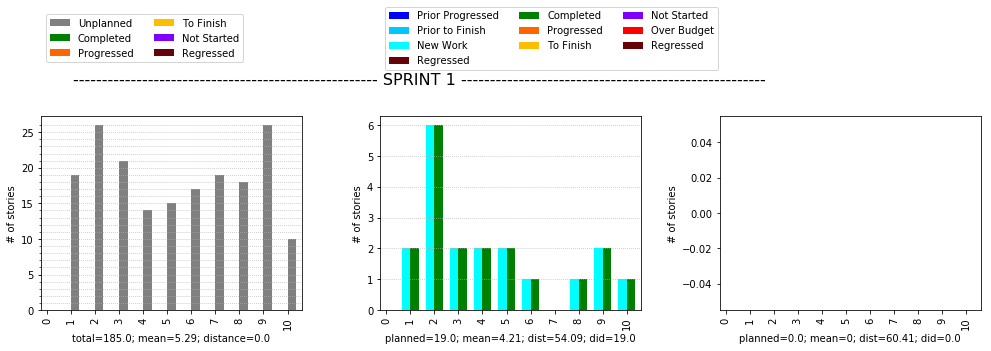

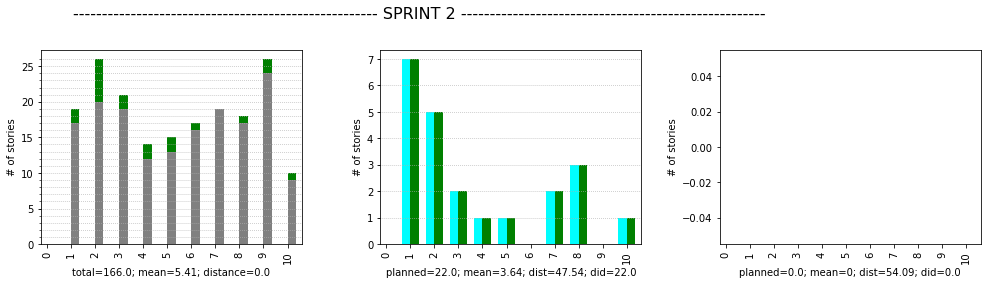

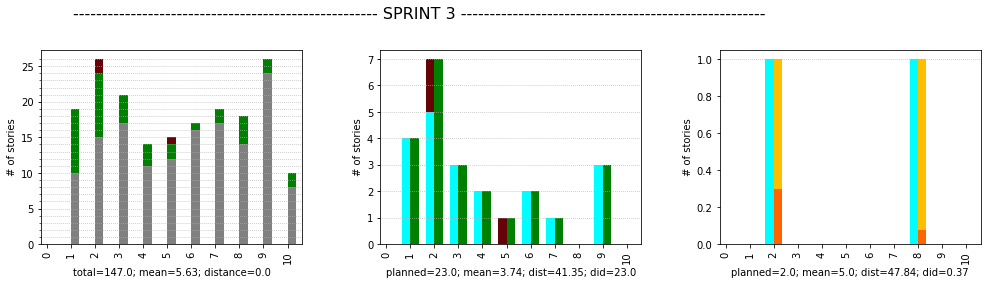

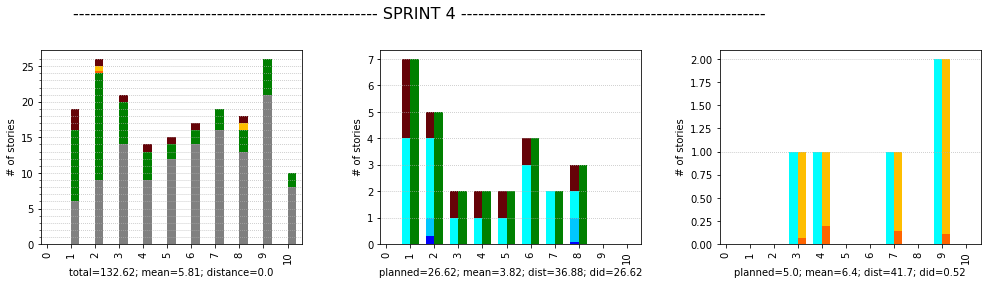

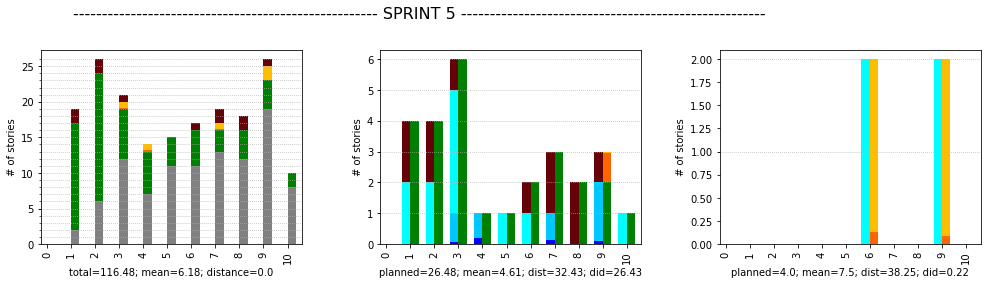

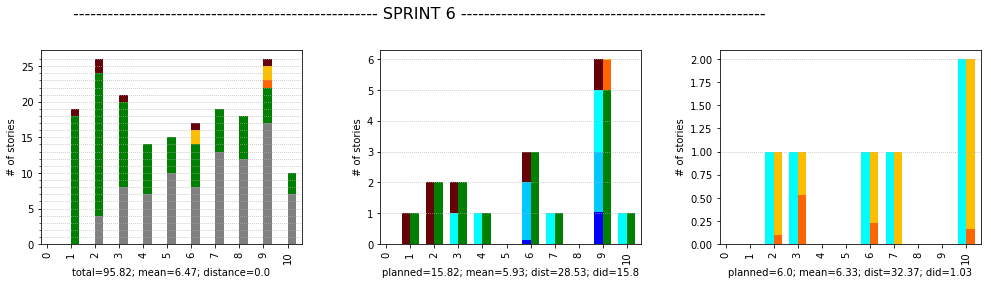

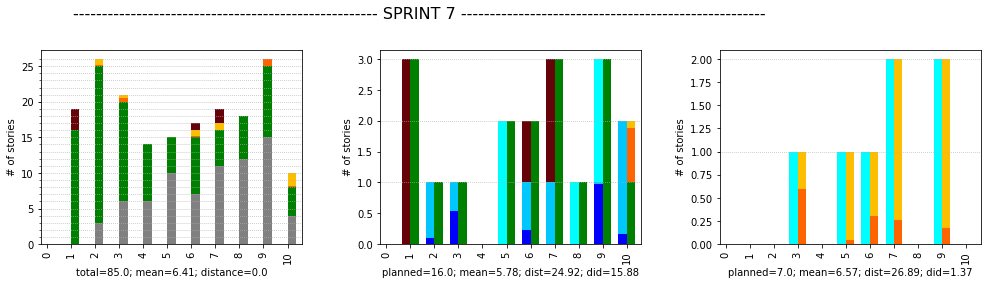

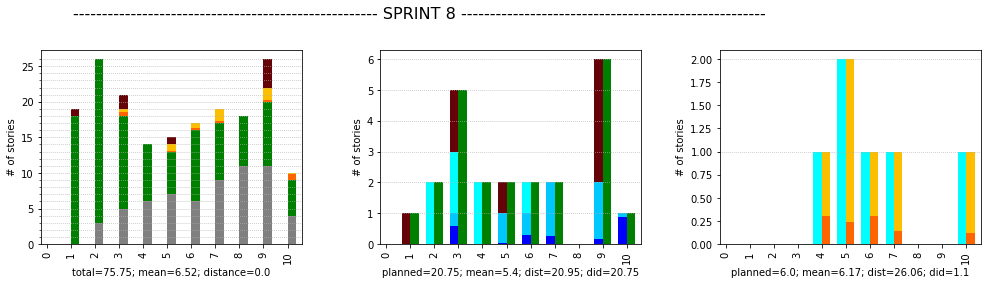

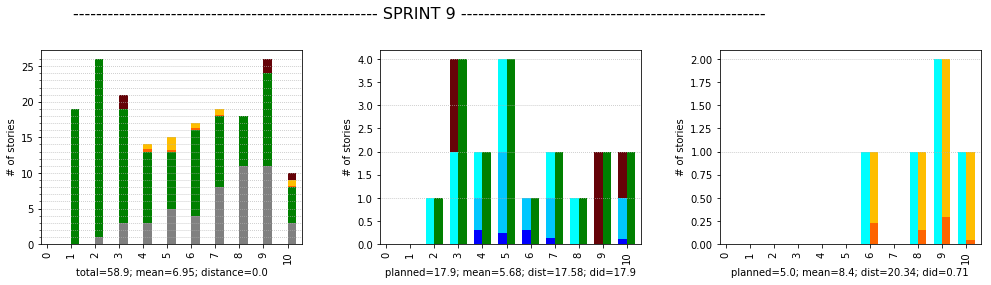

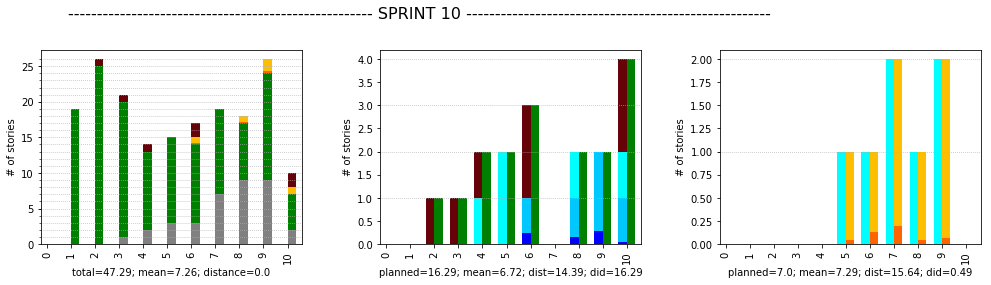

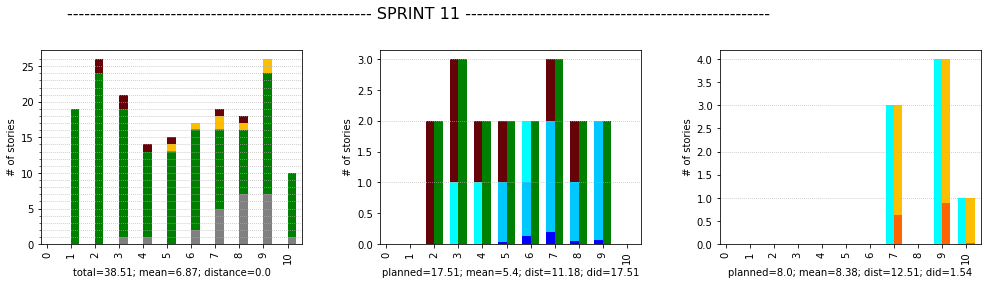

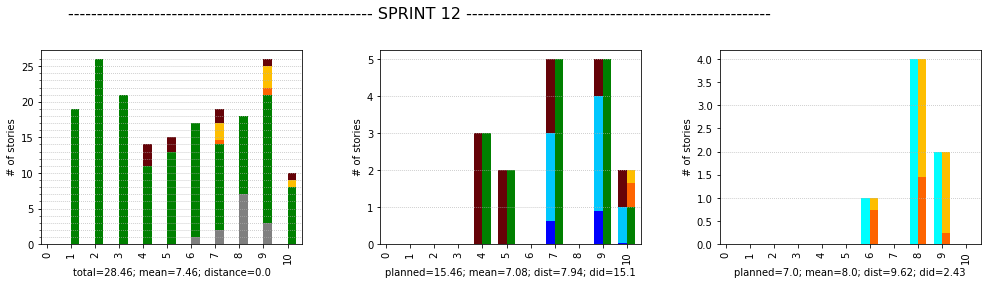

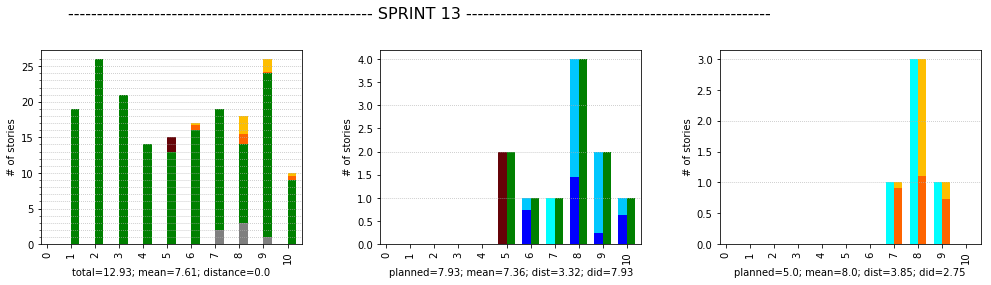

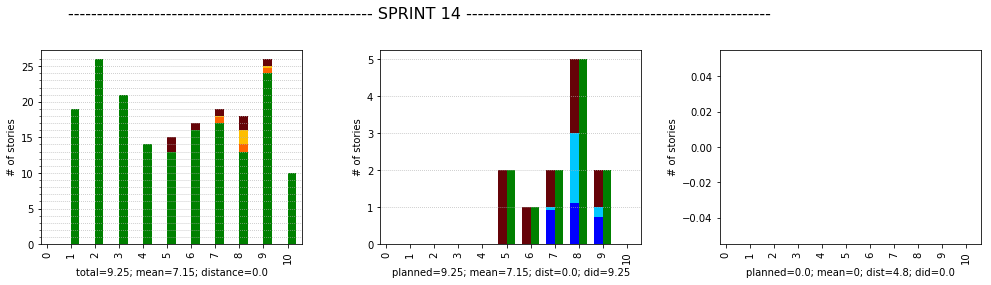

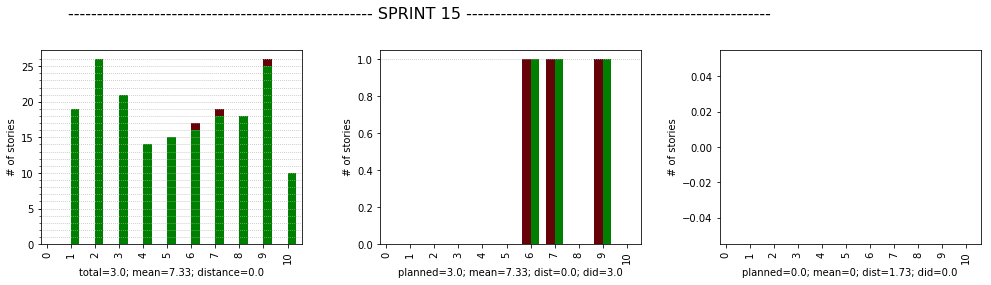

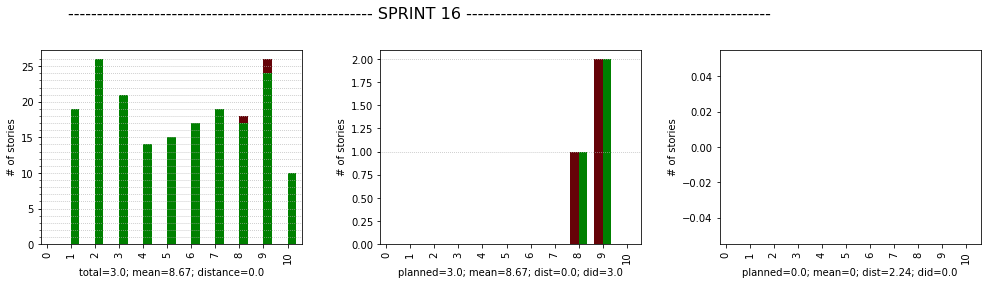

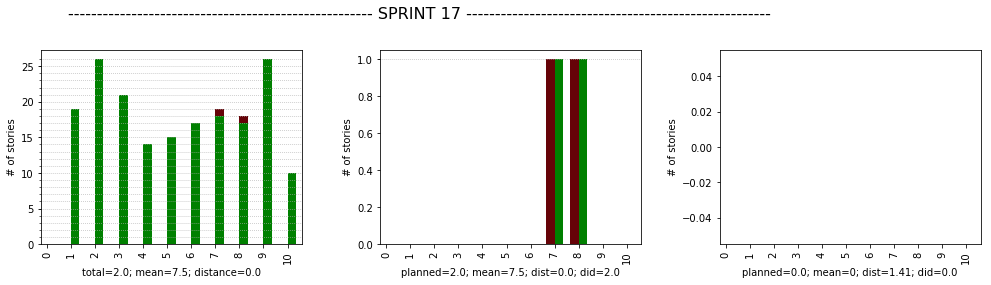

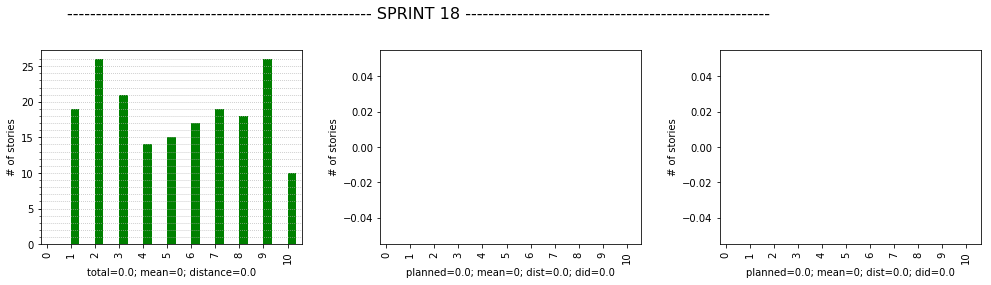

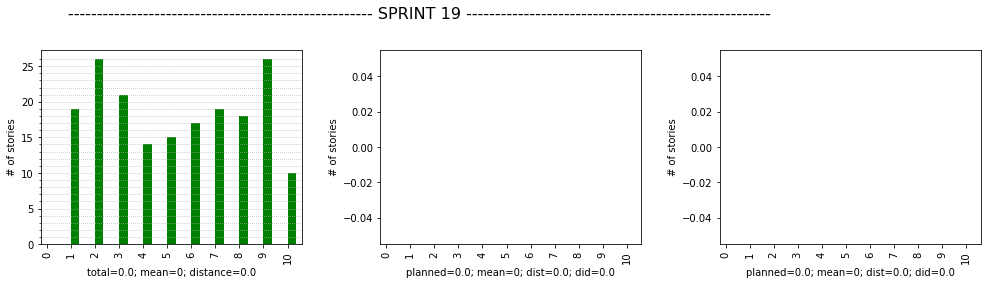

In [9]:
# Uncomment to interactively visualize the release logs, and then comment again once interactive analysis is done. Commenting these
# lines after interactive analysis is completed is required as test harness can't load these visualiations
# libraries so leaving this uncommented will crash the entire test harness.
# NB: MAY NEED TO RUN TWICE (there is a bug in Jupyter notebook, I think, so first time you call this it shows no visuals)
#import devanalyst.simulation.visualizations.timecard_visuals as tc_visuals
#tc_visuals.renderReleaseCycleLog(teamId = 'Team A', release_log=test_buggyReleaseCycle_ACTUAL['log'], first=1, last=19, spurious_columns=['Team Id', 'Sprint'])

In [10]:
# Script to debug test failures when entries change. This was very useful when the test failed because of simply the
# removal of spurious entries (tails of 0's), for which the tu_.taintFailuresToStop was very useful. This allows
# detecting the spurious rows and discard them, and at that point we have the same number of rows. Any mismatches
# after that should be just innocent rotations of some entries, for which tu_.find_mismatches(e2, a) helps find the
# few rows that account for the mismatches, and visual inspection usually is enough to verify it is simply an innocent
# rotation
def spurious_errors_debug(): # return or extract pertinent lines. This function is just a template
    a = test_buggyReleaseCycle_ACTUAL['Entries']
    e = test_buggyReleaseCycle_EXPECTED['Entries']
    at = tu_.taintFailuresToStop(a, 'User Story', 'Time Spent')
    et = tu_.taintFailuresToStop(e, 'User Story', 'Time Spent')
    discard = list(et[et['TAINTED'] == True].index)
    e2 = e.drop(discard)
    e2.index = a.index
    tu_.find_mismatches(e2, a)
    e2.loc[[1178, 1182, 1184, 1216, 1218, 1220, 1232]]
    a.loc[[1178, 1182, 1184, 1216, 1218, 1220, 1232]]

In [11]:
test_buggyReleaseCycle_ACTUAL['Entries'][0:8]

,Sprint,Date,Team,Developer,User Story,Task Type,Task Description,Time Spent
0,1,2018-01-29,Team A,Anton Easterday,UserStory #151,UNFINISHED_STORIES,Story implementation,2.0
1,1,2018-01-29,Team A,Anton Easterday,UserStory #97,UNFINISHED_STORIES,Story implementation,2.0
2,1,2018-01-29,Team A,Anton Easterday,UserStory #58,UNFINISHED_STORIES,Story implementation,4.0
3,1,2018-01-29,Team A,Anton Easterday,UserStory #83,UNFINISHED_STORIES,Story implementation,2.0
4,1,2018-01-29,Team A,Beau Hockensmith,UserStory #1,UNFINISHED_STORIES,Story implementation,10.0
5,1,2018-01-29,Team A,Bruno Studley,UserStory #77,UNFINISHED_STORIES,Story implementation,3.0
6,1,2018-01-29,Team A,Bruno Studley,UserStory #137,UNFINISHED_STORIES,Story implementation,2.0
7,1,2018-01-29,Team A,Bruno Studley,UserStory #52,UNFINISHED_STORIES,Story implementation,5.0


In [12]:
test_buggyReleaseCycle_EXPECTED['Entries'][0:8]

,Sprint,Date,Team,Developer,User Story,Task Type,Task Description,Time Spent
0,1,2018-01-29,Team A,Anton Easterday,UserStory #151,UNFINISHED_STORIES,Story implementation,2.0
1,1,2018-01-29,Team A,Anton Easterday,UserStory #97,UNFINISHED_STORIES,Story implementation,2.0
2,1,2018-01-29,Team A,Anton Easterday,UserStory #58,UNFINISHED_STORIES,Story implementation,4.0
3,1,2018-01-29,Team A,Anton Easterday,UserStory #83,UNFINISHED_STORIES,Story implementation,2.0
4,1,2018-01-29,Team A,Beau Hockensmith,UserStory #1,UNFINISHED_STORIES,Story implementation,10.0
5,1,2018-01-29,Team A,Bruno Studley,UserStory #77,UNFINISHED_STORIES,Story implementation,3.0
6,1,2018-01-29,Team A,Bruno Studley,UserStory #137,UNFINISHED_STORIES,Story implementation,2.0
7,1,2018-01-29,Team A,Bruno Studley,UserStory #52,UNFINISHED_STORIES,Story implementation,5.0


In [13]:
test_buggyReleaseCycle_ACTUAL['User_Stories'][0:8]

,User Story Id,Original Estimate,Team Id,Developer,Product Manager,Percent Achieved,Planned,Sprint Planned,Sprint Delivered,Nb Open Bugs,Open Bugs,Nb Closed Bugs,Closed Bugs
0,UserStory #1,10,Team A,Beau Hockensmith,Sherlyn Cordle,1.0,True,1,1,0,[],0,[]
1,UserStory #2,10,Team A,Beau Hockensmith,Sherlyn Cordle,1.0,True,6,8,0,[],1,[Ticket #179]
2,UserStory #3,4,Team A,Gregorio Darr,Edgar Hibbler,1.0,True,11,11,0,[],0,[]
3,UserStory #4,7,Team A,Gregorio Darr,Sherlyn Cordle,1.0,True,13,14,0,[],1,[Ticket #321]
4,UserStory #5,3,Team A,Beau Hockensmith,Edgar Hibbler,1.0,True,5,5,0,[],0,[]
5,UserStory #6,3,Team A,Bruno Studley,Sherlyn Cordle,1.0,True,3,3,0,[],0,[]
6,UserStory #7,8,Team A,Bruno Studley,Sherlyn Cordle,1.0,True,9,9,0,[],1,[Ticket #201]
7,UserStory #8,9,Team A,Francisco Hoppe,Edgar Hibbler,1.0,True,1,1,0,[],0,[]


In [14]:
test_buggyReleaseCycle_EXPECTED['User_Stories'][0:8]

,User Story Id,Original Estimate,Team Id,Developer,Product Manager,Percent Achieved,Planned,Sprint Planned,Sprint Delivered,Nb Open Bugs,Open Bugs,Nb Closed Bugs,Closed Bugs
0,UserStory #1,10,Team A,Beau Hockensmith,Sherlyn Cordle,1.0,True,1,1,0,[],0,[]
1,UserStory #2,10,Team A,Beau Hockensmith,Sherlyn Cordle,1.0,True,6,8,0,[],1,[Ticket #179]
2,UserStory #3,4,Team A,Gregorio Darr,Edgar Hibbler,1.0,True,11,11,0,[],0,[]
3,UserStory #4,7,Team A,Gregorio Darr,Sherlyn Cordle,1.0,True,13,14,0,[],1,[Ticket #321]
4,UserStory #5,3,Team A,Beau Hockensmith,Edgar Hibbler,1.0,True,5,5,0,[],0,[]
5,UserStory #6,3,Team A,Bruno Studley,Sherlyn Cordle,1.0,True,3,3,0,[],0,[]
6,UserStory #7,8,Team A,Bruno Studley,Sherlyn Cordle,1.0,True,9,9,0,[],1,[Ticket #201]
7,UserStory #8,9,Team A,Francisco Hoppe,Edgar Hibbler,1.0,True,1,1,0,[],0,[]


In [15]:
test_buggyReleaseCycle_ACTUAL['Tickets'][0:8]

,Ticket Id,User Story Id,Estimated Cost,Effort to Date,Percent Achieved,Sprint Reported,Sprint Fixed
0,Ticket #1,UserStory #52,1.0,1.0,1.0,2,3
1,Ticket #2,UserStory #83,0.4,0.4,1.0,2,3
2,Ticket #3,UserStory #137,0.4,0.4,1.0,2,3
3,Ticket #4,UserStory #201,0.8,0.8,1.0,2,3
4,Ticket #5,UserStory #253,1.8,1.8,1.0,2,3
5,Ticket #6,UserStory #502,0.2,0.2,1.0,2,3
6,Ticket #7,UserStory #594,0.8,0.8,1.0,2,3
7,Ticket #8,UserStory #617,0.6,0.6,1.0,2,3


In [16]:
test_buggyReleaseCycle_EXPECTED['Tickets'][0:8]

,Ticket Id,User Story Id,Estimated Cost,Effort to Date,Percent Achieved,Sprint Reported,Sprint Fixed
0,Ticket #1,UserStory #52,1.0,1.0,1.0,2,3
1,Ticket #2,UserStory #83,0.4,0.4,1.0,2,3
2,Ticket #3,UserStory #137,0.4,0.4,1.0,2,3
3,Ticket #4,UserStory #201,0.8,0.8,1.0,2,3
4,Ticket #5,UserStory #253,1.8,1.8,1.0,2,3
5,Ticket #6,UserStory #502,0.2,0.2,1.0,2,3
6,Ticket #7,UserStory #594,0.8,0.8,1.0,2,3
7,Ticket #8,UserStory #617,0.6,0.6,1.0,2,3


In [17]:
test_buggyReleaseCycle_ACTUAL['Burnout']

,Sprint,Stories Started,Stories Progressed,Stories Completed,Effort,Active Developers
0,1,74,74,40,300.0,30
1,2,74,74,41,300.0,30
2,3,78,86,44,300.0,30
3,4,71,110,61,300.0,30
4,5,51,112,65,300.0,30
5,6,47,108,57,300.0,30
6,7,45,94,49,300.0,30
7,8,47,100,48,300.0,30
8,9,46,91,39,300.0,30
9,10,36,85,39,300.0,30


In [18]:
test_buggyReleaseCycle_EXPECTED['Burnout']

,Sprint,Stories Started,Stories Progressed,Stories Completed,Effort,Active Developers
0,1,74,74,40,300.0,30
1,2,74,74,41,300.0,30
2,3,78,86,44,300.0,30
3,4,71,110,61,300.0,30
4,5,51,112,65,300.0,30
5,6,47,108,57,300.0,30
6,7,45,94,49,300.0,30
7,8,47,100,48,300.0,30
8,9,46,91,39,300.0,30
9,10,36,85,39,300.0,30


In [19]:
test_buggyReleaseCycle_ACTUAL['planned_Start_CURRENT_SPRINT'][0:8]

,Breakout,0,1,2,3,4,5,6,7,8,9,10,Team Id,Sprint
0,Prior Progressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
1,Prior to Finish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
2,New Work,0.0,2.0,6.0,2.0,2.0,2.0,1.0,0.0,1.0,2.0,1.0,Team A,1
3,Regressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
4,Prior Progressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2
5,Prior to Finish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2
6,New Work,0.0,7.0,5.0,2.0,1.0,1.0,0.0,2.0,3.0,0.0,1.0,Team A,2
7,Regressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2


In [20]:
test_buggyReleaseCycle_EXPECTED['planned_Start_CURRENT_SPRINT'][0:8]

,Breakout,0,1,2,3,4,5,6,7,8,9,10,Team Id,Sprint
0,Prior Progressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
1,Prior to Finish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
2,New Work,0.0,2.0,6.0,2.0,2.0,2.0,1.0,0.0,1.0,2.0,1.0,Team A,1
3,Regressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
4,Prior Progressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2
5,Prior to Finish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2
6,New Work,0.0,7.0,5.0,2.0,1.0,1.0,0.0,2.0,3.0,0.0,1.0,Team A,2
7,Regressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2


In [21]:
test_buggyReleaseCycle_ACTUAL['planned_End_CURRENT_SPRINT'][0:8]

,Breakout,0,1,2,3,4,5,6,7,8,9,10,Team Id,Sprint
0,Completed,0.0,2.0,6.0,2.0,2.0,2.0,1.0,0.0,1.0,2.0,1.0,Team A,1
1,Progressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
2,To Finish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
3,Not Started,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
4,Over Budget,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
5,Regressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
6,Completed,0.0,7.0,5.0,2.0,1.0,1.0,0.0,2.0,3.0,0.0,1.0,Team A,2
7,Progressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2


In [22]:
test_buggyReleaseCycle_EXPECTED['planned_End_CURRENT_SPRINT'][0:8]

,Breakout,0,1,2,3,4,5,6,7,8,9,10,Team Id,Sprint
0,Completed,0.0,2.0,6.0,2.0,2.0,2.0,1.0,0.0,1.0,2.0,1.0,Team A,1
1,Progressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
2,To Finish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
3,Not Started,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
4,Over Budget,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
5,Regressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
6,Completed,0.0,7.0,5.0,2.0,1.0,1.0,0.0,2.0,3.0,0.0,1.0,Team A,2
7,Progressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2


In [23]:
test_buggyReleaseCycle_ACTUAL['planned_Start_NEXT_SPRINT'][0:8]

,Breakout,0,1,2,3,4,5,6,7,8,9,10,Team Id,Sprint
0,Prior Progressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
1,Prior to Finish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
2,New Work,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
3,Regressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
4,Prior Progressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2
5,Prior to Finish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2
6,New Work,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2
7,Regressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2


In [24]:
test_buggyReleaseCycle_EXPECTED['planned_Start_NEXT_SPRINT'][0:8]

,Breakout,0,1,2,3,4,5,6,7,8,9,10,Team Id,Sprint
0,Prior Progressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
1,Prior to Finish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
2,New Work,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
3,Regressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
4,Prior Progressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2
5,Prior to Finish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2
6,New Work,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2
7,Regressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2


In [25]:
test_buggyReleaseCycle_ACTUAL['planned_End_NEXT_SPRINT'][0:8]

,Breakout,0,1,2,3,4,5,6,7,8,9,10,Team Id,Sprint
0,Completed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
1,Progressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
2,To Finish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
3,Not Started,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
4,Over Budget,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
5,Regressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
6,Completed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2
7,Progressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2


In [26]:
test_buggyReleaseCycle_EXPECTED['planned_End_NEXT_SPRINT'][0:8]

,Breakout,0,1,2,3,4,5,6,7,8,9,10,Team Id,Sprint
0,Completed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
1,Progressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
2,To Finish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
3,Not Started,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
4,Over Budget,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
5,Regressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
6,Completed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2
7,Progressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,2


In [27]:
test_buggyReleaseCycle_ACTUAL['backlog'][0:8]

,Breakout,0,1,2,3,4,5,6,7,8,9,10,Team Id,Sprint
0,Unplanned,0.0,19.0,26.0,21.0,14.0,15.0,17.0,19.0,18.0,26.0,10.0,Team A,1
1,Completed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
2,Progressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
3,To Finish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
4,Not Started,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
5,Regressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
6,Unplanned,0.0,17.0,20.0,19.0,12.0,13.0,16.0,19.0,17.0,24.0,9.0,Team A,2
7,Completed,0.0,2.0,6.0,2.0,2.0,2.0,1.0,0.0,1.0,2.0,1.0,Team A,2


In [28]:
test_buggyReleaseCycle_EXPECTED['backlog'][0:8]

,Breakout,0,1,2,3,4,5,6,7,8,9,10,Team Id,Sprint
0,Unplanned,0.0,19.0,26.0,21.0,14.0,15.0,17.0,19.0,18.0,26.0,10.0,Team A,1
1,Completed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
2,Progressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
3,To Finish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
4,Not Started,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
5,Regressed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Team A,1
6,Unplanned,0.0,17.0,20.0,19.0,12.0,13.0,16.0,19.0,17.0,24.0,9.0,Team A,2
7,Completed,0.0,2.0,6.0,2.0,2.0,2.0,1.0,0.0,1.0,2.0,1.0,Team A,2


In [31]:
test_buggyReleaseCycle_ACTUAL['Resourcing'][0:8]

,Developer,Rejects (days),Rejects (#),Debugging (days),Debugging (#),Implementation (days),Implementation (#),Bandwidth,NEXT SPRINT (days),NEXT SPRINT (#),NEXT SPRINT Bandwidth,Team Id,Sprint
0,Anton Easterday,0.0,0,0.0,0,10.0,4,0.0,0.0,0,10.0,Team A,1
1,Beau Hockensmith,0.0,0,0.0,0,10.0,1,0.0,0.0,0,10.0,Team A,1
2,Bruno Studley,0.0,0,0.0,0,10.0,3,0.0,0.0,0,10.0,Team A,1
3,Craig Garlitz,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0,Team A,1
4,Francisco Hoppe,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0,Team A,1
5,Glenna Mcghie,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0,Team A,1
6,Gregorio Darr,0.0,0,0.0,0,10.0,3,0.0,0.0,0,10.0,Team A,1
7,Heriberto Martini,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0,Team A,1


In [32]:
test_buggyReleaseCycle_EXPECTED['Resourcing'][0:8]

,Developer,Rejects (days),Rejects (#),Debugging (days),Debugging (#),Implementation (days),Implementation (#),Bandwidth,NEXT SPRINT (days),NEXT SPRINT (#),NEXT SPRINT Bandwidth,Team Id,Sprint
0,Anton Easterday,0.0,0,0.0,0,10.0,4,0.0,0.0,0,10.0,Team A,1
1,Beau Hockensmith,0.0,0,0.0,0,10.0,1,0.0,0.0,0,10.0,Team A,1
2,Bruno Studley,0.0,0,0.0,0,10.0,3,0.0,0.0,0,10.0,Team A,1
3,Craig Garlitz,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0,Team A,1
4,Francisco Hoppe,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0,Team A,1
5,Glenna Mcghie,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0,Team A,1
6,Gregorio Darr,0.0,0,0.0,0,10.0,3,0.0,0.0,0,10.0,Team A,1
7,Heriberto Martini,0.0,0,0.0,0,10.0,2,0.0,0.0,0,10.0,Team A,1


In [29]:
test_buggyReleaseCycle_ACTUAL['Outcome'][0:8]

,Owner,Task Type,Task Description,User Story Id,Planned for Sprint,Delivered in Sprint,Original Estimate,Bucket,Effort Spent,Effort Remaining,Percent Achieved,Team Id,Sprint
0,Anton Easterday,UNFINISHED_STORIES,Story implementation,UserStory #151,1.0,1,2.0,CURRENT_SPRINT,2.0,0.0,1.0,Team A,1
1,Anton Easterday,UNFINISHED_STORIES,Story implementation,UserStory #97,1.0,1,2.0,CURRENT_SPRINT,2.0,0.0,1.0,Team A,1
2,Anton Easterday,UNFINISHED_STORIES,Story implementation,UserStory #58,1.0,1,4.0,CURRENT_SPRINT,4.0,0.0,1.0,Team A,1
3,Anton Easterday,UNFINISHED_STORIES,Story implementation,UserStory #83,1.0,1,2.0,CURRENT_SPRINT,2.0,0.0,1.0,Team A,1
4,Beau Hockensmith,UNFINISHED_STORIES,Story implementation,UserStory #1,1.0,1,10.0,CURRENT_SPRINT,10.0,0.0,1.0,Team A,1
5,Bruno Studley,UNFINISHED_STORIES,Story implementation,UserStory #77,1.0,1,3.0,CURRENT_SPRINT,3.0,0.0,1.0,Team A,1
6,Bruno Studley,UNFINISHED_STORIES,Story implementation,UserStory #137,1.0,1,2.0,CURRENT_SPRINT,2.0,0.0,1.0,Team A,1
7,Bruno Studley,UNFINISHED_STORIES,Story implementation,UserStory #52,1.0,1,5.0,CURRENT_SPRINT,5.0,0.0,1.0,Team A,1


In [30]:
test_buggyReleaseCycle_EXPECTED['Outcome'][0:8]

,Owner,Task Type,Task Description,User Story Id,Planned for Sprint,Delivered in Sprint,Original Estimate,Bucket,Effort Spent,Effort Remaining,Percent Achieved,Team Id,Sprint
0,Anton Easterday,UNFINISHED_STORIES,Story implementation,UserStory #151,1.0,1,2.0,CURRENT_SPRINT,2.0,0.0,1.0,Team A,1
1,Anton Easterday,UNFINISHED_STORIES,Story implementation,UserStory #97,1.0,1,2.0,CURRENT_SPRINT,2.0,0.0,1.0,Team A,1
2,Anton Easterday,UNFINISHED_STORIES,Story implementation,UserStory #58,1.0,1,4.0,CURRENT_SPRINT,4.0,0.0,1.0,Team A,1
3,Anton Easterday,UNFINISHED_STORIES,Story implementation,UserStory #83,1.0,1,2.0,CURRENT_SPRINT,2.0,0.0,1.0,Team A,1
4,Beau Hockensmith,UNFINISHED_STORIES,Story implementation,UserStory #1,1.0,1,10.0,CURRENT_SPRINT,10.0,0.0,1.0,Team A,1
5,Bruno Studley,UNFINISHED_STORIES,Story implementation,UserStory #77,1.0,1,3.0,CURRENT_SPRINT,3.0,0.0,1.0,Team A,1
6,Bruno Studley,UNFINISHED_STORIES,Story implementation,UserStory #137,1.0,1,2.0,CURRENT_SPRINT,2.0,0.0,1.0,Team A,1
7,Bruno Studley,UNFINISHED_STORIES,Story implementation,UserStory #52,1.0,1,5.0,CURRENT_SPRINT,5.0,0.0,1.0,Team A,1
